# PyMC3 Implementation

The aim here is implement the Metropolis - Hastings algorithm, Slice Sampling, Elliptical Slice Sampling(ESS) and No - U - Turn Sampling(NUTS) on multivariate normal data of varying dimensions and estimate the 𝝁 vector.

### Packages

In [1]:
!pip install pymc3
!pip install arviz
!pip install corner

     |████████████████████████████████| 1.3MB 4.9MB/s 
     |████████████████████████████████| 4.1MB 30.2MB/s 
     |████████████████████████████████| 307kB 46.8MB/s 
  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11643 sha256=c8ce626d3714b2a8e9dbf78818815fb22e906f4d4fd5d4ce1ec9a574a1cb9684
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import scipy as sp
from theano import tensor as T
%matplotlib inline
import time
import corner as corner

### Data step

Here we will make use of multivariate normal data randomly generately directly by Python.

However, to make the procedure reproducible, we set the seed such that the same random numbers will be drawn every run of the program.

In [0]:
np.random.seed(123)

#### Dimension and sample size specification: 

The code below can be changed such that the number of variables being considered is changed, as to can the sample size of the multivariate normal sample.

In [0]:
N = 200 #The sample size of the multivariate normal sample.
mu_min, mu_max = -5,10 #The range for the mu component values
cov_min, cov_max = 0, 0.1 #The range for the cov component values
n_samples = 11000
n_burn = 1100
n_thin = 2
Calc_time = []
Calc_effective = []
Calc_gelman = []
Std_Err = []

# Model Implementation


## Metropolis:

In [0]:
for k in range(2,11):
    np.random.seed(123)
    mu_actual = sp.stats.uniform.rvs(mu_min, mu_max, size=k)
    #print ("The true mean vector is: ", mu_actual)
    cov_actual_sqrt = sp.stats.uniform.rvs(cov_min, cov_max, size=(k, k))
    cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)
    #print ("The true covariance matrix is: ", cov_actual)
    
    x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=N) 
    
    with pm.Model() as model:
        sigma = pm.Lognormal('sigma', np.zeros(k), np.ones(k), shape=k)
    
        nu = pm.Uniform('nu', 0, 5)
        C_triu = pm.LKJCorr('C_triu', nu, k)
    
    C_triu.tag.test_value.shape
    
    
    with model:
        C = pm.Deterministic('C', T.fill_diagonal(C_triu[np.zeros((k, k), dtype=np.int64)], 1.))
    
        sigma_diag = pm.Deterministic('sigma_mat', T.nlinalg.diag(sigma))
        cov = pm.Deterministic('cov', T.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))
        tau = pm.Deterministic('tau', T.nlinalg.matrix_inverse(cov))
    
    with model:
        mu = pm.MvNormal('mu', 0, tau, shape=k)
    
        x_ = pm.MvNormal('x', mu, tau, observed=x)
        
    start = time.time()
    with model:
        step = pm.Metropolis()
        trace_ = pm.sample(n_samples, step)
    end = time.time()
    
    Calc_time.append(end - start)
    print("The computation times are: ",Calc_time)
    
    trace = trace_[n_burn::n_thin]
    eff = pm.effective_n(trace,['mu'])
    mean_eff = np.array(list(eff.values())).mean()
    Calc_effective.append(mean_eff)
    print("The effective samples are: ",Calc_effective)

    gel = pm.gelman_rubin(trace, ['mu'])
    mean_gel = np.array(list(gel.values())).mean()
    Calc_gelman.append(mean_gel)
    print("The Gelman-Rubin statistics is :",Calc_gelman)

    Std_Err.append(trace['mu'].std(axis=0))
    print("The Standard Errors are :",Std_Err)

    #pm.traceplot(trace, ['mu'], figsize = (12,5));

## Slice Sampling

For high covariance it breaks! I.e above 3.5

In [0]:
for k in range(9,10):
    np.random.seed(123)
    mu_actual = sp.stats.uniform.rvs(mu_min, mu_max, size=k)
    #print ("The true mean vector is: ", mu_actual)
    cov_actual_sqrt = sp.stats.uniform.rvs(cov_min, cov_max, size=(k, k))
    cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)
    #print ("The true covariance matrix is: ", cov_actual)
    
    x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=200) 

    with pm.Model() as model:
      packed_L = pm.LKJCholeskyCov('packed_L', n=k,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
      packed_L.tag.test_value.shape
    
    with model:
      L = pm.expand_packed_triangular(k, packed_L)
      Σ = pm.Deterministic('Σ', L.dot(L.T))
      L.tag.test_value.shape
    
    with model:
      μ = pm.Normal('μ', 0., 10., shape=k,
                  testval=x.mean(axis=0))
      obs = pm.MvNormal('obs', μ, chol=L, observed=x)

    start = time.time()
    with model:
        step = pm.Slice()
        trace_ = pm.sample(n_samples,step)
    end = time.time()

    Calc_time.append(end - start)
    print("The computation times are: ",Calc_time)
    
    trace = trace_[n_burn::n_thin]
    eff = pm.effective_n(trace,['μ'])
    mean_eff = np.array(list(eff.values())).mean()
    Calc_effective.append(mean_eff)
    print("The effective samples are: ",Calc_effective)

    gel = pm.gelman_rubin(trace,['μ'])
    mean_gel = np.array(list(gel.values())).mean()
    Calc_gelman.append(mean_gel)
    print("The Gelman-Rubin statistics is :",Calc_gelman)

    Std_Err.append(trace['μ'].std(axis=0))
    print("The Standard Errors are :",Std_Err)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [μ]
>Slice: [packed_L]
  0%|          | 0/11500 [00:00<?, ?it/s]WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for bl

The computation times are:  [3907.8732612133026]
The effective samples are:  [3.9271587387375795]
The Gelman-Rubin statistics is : [1.7891137218711641]
The Standard Errors are : [array([ 0.37761633,  0.45911379,  1.36063297, 10.7050907 , 22.97009505,
        0.38376798,  0.42109115, 12.73777101, 11.26846773])]


## Elliptical Slice Sampling

In [0]:
for k in range(10,11):
    np.random.seed(123)
    mu_actual = sp.stats.uniform.rvs(mu_min, mu_max, size=k)
    #print ("The true mean vector is: ", mu_actual)
    cov_actual_sqrt = sp.stats.uniform.rvs(cov_min, cov_max, size=(k, k))
    cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)
    #print ("The true covariance matrix is: ", cov_actual)
    
    x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=N) 
    
    with pm.Model() as model:
        sigma = pm.Lognormal('sigma', np.zeros(k), np.ones(k), shape=k)
    
        nu = pm.Uniform('nu', 0, 5)
        C_triu = pm.LKJCorr('C_triu', nu, 2)
    
    C_triu.tag.test_value.shape
    
    
    with model:
        C = pm.Deterministic('C', T.fill_diagonal(C_triu[np.zeros((k, k), dtype=np.int64)], 1.))
    
        sigma_diag = pm.Deterministic('sigma_mat', T.nlinalg.diag(sigma))
        cov = pm.Deterministic('cov', T.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))
        tau = pm.Deterministic('tau', T.nlinalg.matrix_inverse(cov))
    
    with model:
        mu = pm.MvNormal('mu', 0, tau, shape=k)
    
        x_ = pm.MvNormal('x', mu, tau, observed=x)
        
    start = time.time()
    with model:
        step = pm.EllipticalSlice(prior_chol=C_triu)
        trace_ = pm.sample(n_samples,step)
        
    end = time.time()
    
    Calc_time.append(end - start)
    print("The computation times are: ",Calc_time)
    
    trace = trace_[n_burn::n_thin]
    eff = pm.effective_n(trace,['mu'])
    mean_eff = np.array(list(eff.values())).mean()
    Calc_effective.append(mean_eff)
    print("The effective samples are: ",Calc_effective)

    gel = pm.gelman_rubin(trace, ['mu'])
    mean_gel = np.array(list(gel.values())).mean()
    Calc_gelman.append(mean_gel)
    print("The Gelman-Rubin statistics is :",Calc_gelman)

    Std_Err.append(trace['mu'].std(axis=0))
    print("The Standard Errors are :",Std_Err)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
EllipticalSlice: [mu, C_triu, nu, sigma]
100%|██████████| 11500/11500 [18:19<00:00, 10.46it/s]


The computation times are:  [2173.2199988365173]
The effective samples are:  [9702.354415064934]
The Gelman-Rubin statistics is : [0.9999049832883816]
The Standard Errors are : [array([0.00203026, 0.00203026, 0.00203026, 0.00203026, 0.00203026,
       0.00203026, 0.00203026, 0.00203026, 0.00203026, 0.00203026])]


## NUTS:

In [0]:
for k in range(10,11):
    np.random.seed(123)
    mu_actual = sp.stats.uniform.rvs(mu_min, mu_max, size=k)
    #print ("The true mean vector is: ", mu_actual)
    cov_actual_sqrt = sp.stats.uniform.rvs(cov_min, cov_max, size=(k, k))
    cov_actual = np.dot(cov_actual_sqrt.T, cov_actual_sqrt)
    #print ("The true covariance matrix is: ", cov_actual)
    
    x = sp.stats.multivariate_normal.rvs(mu_actual, cov_actual, size=200) 

    with pm.Model() as model:
      packed_L = pm.LKJCholeskyCov('packed_L', n=k,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
      packed_L.tag.test_value.shape
    
    with model:
      L = pm.expand_packed_triangular(k, packed_L)
      Σ = pm.Deterministic('Σ', L.dot(L.T))
      L.tag.test_value.shape
    
    with model:
      μ = pm.Normal('μ', 0., 10., shape=k,
                  testval=x.mean(axis=0))
      obs = pm.MvNormal('obs', μ, chol=L, observed=x)

    start = time.time()
    with model:
        trace_ = pm.sample(n_samples)
    end = time.time()

    Calc_time.append(end - start)
    print("The computation times are: ",Calc_time)
    
    trace = trace_[n_burn::n_thin]
    eff = pm.effective_n(trace,['μ'])
    mean_eff = np.array(list(eff.values())).mean()
    Calc_effective.append(mean_eff)
    print("The effective samples are: ",Calc_effective)

    gel = pm.gelman_rubin(trace,['μ'])
    mean_gel = np.array(list(gel.values())).mean()
    Calc_gelman.append(mean_gel)
    print("The Gelman-Rubin statistics is :",Calc_gelman)

    Std_Err.append(trace['μ'].std(axis=0))
    print("The Standard Errors are :",Std_Err)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.6/dist-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `

The computation times are:  [11355.47949886322]
The effective samples are:  [5116.690240491301]
The Gelman-Rubin statistics is : [0.9999616862501371]
The Standard Errors are : [array([0.00915769, 0.01444771, 0.00950427, 0.01010719, 0.01164178,
       0.01072398, 0.01010767, 0.00991032, 0.01092983, 0.00988131])]


# Results

Preliminary steps before graphing:

In [0]:
k = np.arange(2,11,1)

## Medium Covariance:

In [0]:
Met_time_med = [67.91765093803406, 68.62413287162781, 67.98617243766785, 68.5471351146698, 71.84945178031921, 73.78271555900574, 74.66702175140381, 76.18038392066956, 78.74131155014038]
Met_Gel_med = [1.0008189849887834, 1.0093064880338618, 1.0077258728545204, 1.0055485697482465, 1.00230394930548, 1.004544030408264, 1.1162426762621653, 1.119525376103063, 1.528796586072748]
Met_Eff_med = [1104.1773729638844, 164.1416125674164, 27.690826109483083, 24.017820322932113, 31.52909012580311, 48.48132285879399, 7.775484238939295, 11.646488045653662, 2.8625150251836424]
Met_Std_med = [np.array([0.10416212, 0.09505707]), np.array([0.1862334 , 0.16456173, 0.16288171]), np.array([0.13028059, 0.08383777, 0.16463214, 0.17718529]), np.array([0.15569062, 0.2138213 , 0.15731944, 0.13113586, 0.1654981 ]), np.array([0.20507156, 0.17381454, 0.19150659, 0.19184458, 0.15944418,
       0.16987076]), np.array([0.15580969, 0.16203473, 0.17712211, 0.17130389, 0.13943971, 0.15238938, 0.12006323]), np.array([0.26841672, 0.20143417, 0.23613354, 0.26126539, 0.26093512,0.28858188, 0.26945058, 0.2964532 ]), np.array([0.07726394, 0.12396098, 0.12699303, 0.09127668, 0.09680506,
       0.08043804, 0.09933412, 0.0982688 , 0.10016042]), np.array([0.19868996, 0.31224589, 0.26137087, 0.24628789, 0.30095952,0.21727371, 0.23824587, 0.33197229, 0.20256733, 0.20658036])]

Slice_time_med = [229.6821882724762, 349.18977189064026, 528.6493802070618, 835.2350475788116, 1150.474859237671, 1499.596940279007, 2133.8532960414886, 2335.20694231987, 3120.216454744339]
Slice_Gel_med = [1.000489544265085, 1.0000781376268102, 1.001856454176728, 1.0002888822550926, 1.0062075188045798, 1.0029719181239536, 1.067646596139571, 1.0278416563759536, 1.0144425577055818]
Slice_Eff_med = [3730.053914558547, 537.4957874442238, 326.3086262892173, 79.4319001473729, 50.21618195588286, 73.02093816327168, 4.559717612342151, 25.685769683887276, 5.0726320315545586]
Slice_Std_med = [np.array([0.10650721, 0.09700768]), np.array([0.17892362, 0.15955544, 0.15506025]), np.array([0.14588858, 0.09158549, 0.17991957, 0.19882474]), np.array([0.15817056, 0.21980729, 0.15864743, 0.13189331, 0.16538156]), np.array([0.23459394, 0.23344506, 0.24479944, 0.2303631 , 0.2014652 ,
       0.19337814]), np.array([0.21190871, 0.22140512, 0.24488742, 0.21524577, 0.19998047, 0.2259183 , 0.15099021]), np.array([0.7296776 , 0.61390607, 1.2199047 , 1.13641643, 1.73898173, 1.88272439, 2.02378626, 1.70648464]), np.array([0.22556157, 0.28039488, 0.32318293, 0.29575638, 0.30564794,
       0.18009312, 0.29399547, 0.2272352 , 0.27853766]), np.array([0.34681349, 0.58227737, 0.64445344, 0.61352972, 0.9385585 , 0.78602585, 1.86034121, 2.29646073, 2.40845995, 1.2405659 ])]

ESS_time_med = [1821.3341319561005, 1813.7641322612762, 1828.0601992607117, 1897.4970889091492, 1934.2252345085144, 1971.961592912674, 2006.2891721725464, 1992.850355386734, 2012.7389867305756]
ESS_Gel_med = [1.0001423577179296, 0.9999585874305089, 0.9999002272870701, 0.9999185062592094, 0.9999170984942488, 0.9999101476518061, 1.0001877074921535, 0.9999742654692698, 1.0000389068155875]
ESS_Eff_med = [5376.215644102248, 7084.569439309246, 9169.696470667113, 9398.542077568804, 9140.743158717209, 9145.933301714276, 9849.031959465246, 9521.136989649707, 9568.483145635078]
ESS_Std_med = [np.array([0.03615877, 0.03615877]), np.array([0.01635503, 0.01635503, 0.01635503]), np.array([0.00687267, 0.00687267, 0.00687267, 0.00687267]), np.array([0.00301442, 0.00301442, 0.00301442, 0.00301442, 0.00301442]), np.array([0.00154491, 0.00154491, 0.00154491, 0.00154491, 0.00154491,
       0.00154491]), np.array([0.00088752, 0.00088752, 0.00088752, 0.00088752, 0.00088752, 0.00088752, 0.00088752]), np.array([0.00058045, 0.00058045, 0.00058045, 0.00058045, 0.00058045, 0.00058045, 0.00058045, 0.00058045]), np.array([0.00040644, 0.00040644, 0.00040644, 0.00040644, 0.00040644,
       0.00040644, 0.00040644, 0.00040644, 0.00040644]), np.array([0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241, 0.00031241])]

NUTS_time_med = [83.12328290939331, 209.48024082183838, 205.10020470619202, 583.9570553302765, 921.4386925697327, 691.7844030857086, 3954.3368303775787, 995.8852186203003, 7446.224649429321]
NUTS_Gel_med = [0.9999392229729749, 0.9999610284898613, 0.9999689784816856, 0.9999009440636357, 0.9999630299412142, 1.0001432633135905, 1.0012473717277457, 0.9999744969028116, 1.0000559448532922]
NUTS_Eff_med = [9038.136215938604, 8182.883845048872, 6780.056924647106, 6853.961874759142, 6370.18575714323, 6195.523403981346, 4065.6603396334053, 4163.695272037727, 5416.508903131066]
NUTS_Std_med = [np.array([0.10652771, 0.09747477]), np.array([0.17159736, 0.15365713, 0.14921802]), np.array([0.14577589, 0.09097341, 0.18047346, 0.20033981]), np.array([0.15306035, 0.21254097, 0.15337756, 0.12726376, 0.15856549]), np.array([0.21057812, 0.19854212, 0.20694866, 0.19758478, 0.16959376,0.17341012]), 
                np.array([0.18518057, 0.19070223, 0.21329992, 0.18921274, 0.17256476, 0.1926033 , 0.13236898]), np.array([0.19427717, 0.14657392, 0.18423239, 0.18515395, 0.19857872,0.22192136, 0.1864671 , 0.22973605]), np.array([0.17861842, 0.21809364, 0.23032427, 0.22724136, 0.21611457,0.13370081, 0.21439259, 
               0.16344055, 0.21020944]), np.array([0.17753358, 0.28472826, 0.18613814, 0.19769063, 0.2270037 ,0.20933059, 0.19877557, 0.19719891, 0.2154304 , 0.19329829])]


## Zero Covariance:

In [0]:
Met_time = [65.8791823387146, 67.85873293876648, 68.46582627296448, 71.26160979270935, 71.53019833564758, 74.50295805931091, 76.05470108985901, 76.24119877815247, 79.18877696990967]
Met_Gel = [1.1675597324955032, 1.1372975813657797, 1.4513976665688686, 1.5726545212965288, 1.6529009690297451, 1.3629680493325977, 2.0399730356430683, 7.557473376640159, 11.58749511141407]
Met_Eff = [11.775376946012223, 6.829183944649842, 3.7223046439418708, 2.5608649126287197, 3.818181260060461, 21.392832709975107, 13.429041178594632, 1.1584757868111437, 5.398629869992687]
Met_Std = [np.array([0.00776741, 0.00844405]), np.array([0.01039386, 0.01703215, 0.23279057]), np.array([0.41165211, 0.70338161, 0.62835202, 0.00817051]), np.array([0.07259802, 0.29833286, 0.90805833, 0.0207262 , 0.09305294]), np.array([0.03493118, 0.18412219, 0.65511086, 0.0080148 , 0.02778334,
       0.00856565]), np.array([0.02075541, 0.01814224, 0.43092964, 0.00532171, 0.2180758 ,0.00769593, 0.38995869]), np.array([0.0285174 , 0.09991676, 0.10025648, 0.00426927, 0.04956728,
       0.00559454, 1.6633216 , 0.01737834]), np.array([0.26560932, 0.72122053, 0.49155728, 0.0573501 , 0.55868218,0.12988921, 2.1343108 , 0.59219518, 0.01540575]), np.array([0.25529821, 0.0606126 , 1.96300727, 0.00546113, 0.26749563,0.01250692, 2.15228636, 0.03160172, 1.18019662, 0.01283639])]

Slice_time = [164.0692594051361, 293.5343837738037, 435.8572278022766, 719.360392332077, 1547.1470894813538, 1788.9338781833649, 3190.6323647499084, 3310.09375500679, 4472.243134737015]
Slice_Gel = [1.0001118543675864, 1.0104025554395246, 1.0090210485862308, 1.018615114477347, 2.331192066554672, 1.358308069667803, 9.13374436450015, 2.861311309093173, 6.319790584563781]
Slice_Eff = [3876.7718770315314, 476.22365810941955, 375.31097214944043, 47.16868736683289, 3.875138521097989, 9.439371571411387, 1.144219198166856, 1.4990375887276366, 1.7404192875786777]
Slice_Std = [np.array([0.00052831, 0.00048734]), np.array([0.00088552, 0.00078857, 0.00076862]), np.array([0.00078513, 0.00048721, 0.00096842, 0.0010724 ]), np.array([0.00083851, 0.00163937, 0.00093893, 0.00553334, 0.00514746]), np.array([0.01551426, 0.01295662, 0.02049819, 0.03542136, 0.02190175,
       0.06651763]), np.array([0.00404561, 0.00476523, 0.00695512, 0.00517139, 0.00567494, 0.03926004, 0.10396255]), np.array([0.0031134 , 0.0020538 , 0.00272893, 0.00430899, 0.03710109, 0.05056391, 0.01979387, 0.02744457]), np.array([0.00283598, 0.00296318, 0.00602233, 0.00369576, 0.00624281,
       0.02835931, 0.05613376, 0.02976305, 0.01802764]), np.array([0.07153059, 0.02124177, 0.00248327, 0.00435648, 0.05694465, 0.0583343 , 0.05627643, 0.03970238, 0.01545904, 0.03142514])]

ESS_time = [1878.3022532463074, 1866.8121378421783,1946.6710631847382, 1946.2456891536713, 1942.2583112716675, 1996.422835111618, 2054.2536079883575, 2114.797774076462, 2173.2199988365173]
ESS_Gel = [0.9999818822953217, 0.9999004384591575, 0.9999006274199663, 0.9999175159228704, 1.000453375615604, 0.9999309348135191, 0.9999191141571221, 0.9999250759124728, 0.9999049832883816]
ESS_Eff = [6104.313736518816, 7538.6770593416395,7243.684585678588, 8458.623777157929, 8776.692058395616, 9440.131452208183, 8836.298384093225, 9391.55297657436, 9702.354415064934]
ESS_Std = [np.array([0.03881738, 0.03881738]), np.array([0.0228289, 0.0228289, 0.0228289]),np.array([0.01576993, 0.01576993, 0.01576993, 0.01576993]), 
           np.array([0.00940814, 0.00940814, 0.00940814, 0.00940814, 0.00940814]), np.array([0.00841001, 0.00841001, 0.00841001, 0.00841001, 0.00841001,
       0.00841001]), np.array([0.00263436, 0.00263436, 0.00263436, 0.00263436, 0.00263436, 0.00263436, 0.00263436]), np.array([0.00208269, 0.00208269, 0.00208269, 0.00208269, 0.00208269,
       0.00208269, 0.00208269, 0.00208269]), np.array([0.00197905, 0.00197905, 0.00197905, 0.00197905, 0.00197905,
       0.00197905, 0.00197905, 0.00197905, 0.00197905]), np.array([0.00203026, 0.00203026, 0.00203026, 0.00203026, 0.00203026,
       0.00203026, 0.00203026, 0.00203026, 0.00203026, 0.00203026])]

NUTS_time = [148.20205354690552, 367.62183237075806, 385.86099767684937, 1493.6192481517792, 3248.957775592804, 1641.6114590168, 14928.658458471298, 3498.590024471283, 11355.47949886322]
NUTS_Gel = [0.9999681617565208, 1.0002059738703089, 1.000096432992782, 0.9999255677489349, 0.999939567475146, 1.0000762034128188, 1.001699136289069, 1.0000434344631286, 0.9999616862501371]
NUTS_Eff = [8473.823619160241, 8515.136651237457, 7323.824578010099, 6603.414665894093, 5006.66667958829, 5838.150775949373, 560.7483850337522, 4407.440435771731, 5116.690240491301]
NUTS_Std = [np.array([0.00053191, 0.00048193]), np.array([0.00087173, 0.00077807, 0.00075594]), np.array([0.00073496, 0.00045978, 0.00090848, 0.00100697]), np.array([0.0007899 , 0.00108466, 0.00078458, 0.00065691, 0.00082653]), np.array([0.00102562, 0.00099449, 0.0010358 , 0.00098046, 0.00085031,
            0.0008519 ]), np.array([0.00090588, 0.00093494, 0.00105928, 0.00093844, 0.00084657, 0.00095229, 0.00065344]), np.array([0.00098927, 0.00078326, 0.0009321 , 0.0009692 , 0.00106171, 0.0022858 , 0.01525877, 0.00877187]), np.array([0.00089188, 0.00109776, 0.00115717, 0.00113432, 0.00108927,
            0.00067065, 0.00107504, 0.00082321, 0.00106307]), np.array([0.00915769, 0.01444771, 0.00950427, 0.01010719, 0.01164178,0.01072398, 0.01010767, 0.00991032, 0.01092983, 0.00988131])]

## High Covariance:

In [0]:
Met_time_high = [66.95094442367554, 68.6311948299408, 70.49021244049072, 70.98546600341797, 72.14961624145508, 75.74394178390503, 77.04520225524902, 76.30571126937866, 77.92054581642151]
Met_Gel_high = [1.000215537872862, 1.0012675849431358, 1.0001443002310275, 1.119031440703807, 1.0005580255317998, 1.033985688379217, 1.093548184351683, 1.035560337228657, 1.1419567107798603]
Met_Eff_high = [1052.7222343267438, 175.34357613083557, 75.0498259050368, 15.441952876640789, 48.63116348222832, 38.79184802497902, 21.451016320213, 16.020702341507363, 12.412973940256942]
Met_Std_high = [np.array([0.53013601, 0.48381825]), np.array([0.88805512, 0.77521348, 0.77740015]), np.array([0.72690952, 0.4709313 , 0.91753877, 1.0052208 ]), np.array([0.83852668, 1.15965073, 0.84368157, 0.68389463, 0.86615984]), np.array([0.9660091 , 0.91601727, 0.95501084, 0.92785703, 0.76310678,
       0.80408448]), np.array([0.87778345, 0.9693791 , 1.05206236, 0.94149642, 0.80958487,0.93213011, 0.66865746]), np.array([1.04123029, 0.7478183 , 0.97951644, 0.94365594, 1.05055622,1.20482504, 0.9990581 , 1.19058305]), np.array([0.90092164, 1.21417446, 1.18162432, 1.15226889, 1.11097067,
       0.71887397, 1.08741287, 0.89145351, 1.03830413]), np.array([0.82869648, 1.53965593, 0.86653082, 0.85525038, 1.08792797, 1.07216506, 0.94863657, 1.10747391, 1.07026279, 0.82005477])]

Slice_time_high = [139.59877490997314, 302.15500473976135, 385.90900897979736, 637.6684448719025, 1295.0343279838562, 1538.9920694828033, 1949.6939895153046, 3907.8732612133026,3979.936637878418]
Slice_Gel_high = [1.0013315376415761, 1.0014167582818194, 1.0028988074961758, 1.2516221266409688, 1.548965616473181, 1.0168260870411212, 1.0319369932580615, 1.7891137218711641,2.6835812422391414]
Slice_Eff_high = [3490.547802386941, 443.8175212977276, 352.9633360438166, 4.577989325845108, 3.0383394932380106, 74.77755202286933, 4.7908141548605165, 3.9271587387375795 ,1.3266602220007548]
Slice_Std_high = [np.array([0.15821301, 0.14292016]), np.array([0.26664125, 0.23773027, 0.23059204]), np.array([0.22304666, 0.13974876, 0.27519784, 0.30476107]), np.array([1.72908092, 2.97817028, 2.13936796, 1.45025703, 1.87457542]), np.array([1.57612188, 2.77919422, 3.31065198, 4.37874797, 3.75666183,
       2.89891057]), np.array([0.28679093, 0.29724998, 0.34371986, 0.29969086, 0.27188347, 0.31367046, 0.20950489]), np.array([1.13075113, 0.9922224 , 1.55114666, 1.8750685 , 3.66208578, 4.16117713, 4.37685701, 2.7827078 ]),np.array([ 0.37761633,  0.45911379,  1.36063297, 10.7050907 , 22.97009505,
        0.38376798,  0.42109115, 12.73777101, 11.26846773]) , np.array([ 0.87655516,  1.77599082,  1.20610993,  1.22802092,  1.11259821, 1.23549213,  2.5908136 ,  7.88338411, 19.24404141, 15.0660306 ])]

ESS_time_high = [1830.4800171852112, 1897.7116694450378, 1937.44051861763, 2060.552443742752, 2090.8620505332947, 2051.690839290619, 2223.1674406528473,2119.2444446086884, 2096.411407470703]
ESS_Gel_high = [0.9999059310198184, 1.0000648296814147, 0.9999821051944793, 0.9999016518972657, 1.000785478727021, 0.999977315099155, 0.9998997793915845,0.9999773026386571, 0.9999299104280744]
ESS_Eff_high = [4712.436221778884, 8864.104543761505, 9802.888837572205, 9724.520357119995, 9419.294437788834, 9803.3912834137, 9684.666917652643,9829.510737910237, 9365.498379635726]
ESS_Std_high = [np.array([0.03069762, 0.03069762]), np.array([0.00240465, 0.00240465, 0.00240465]), np.array([0.0004997, 0.0004997, 0.0004997, 0.0004997]), np.array([0.00019052, 0.00019052, 0.00019052, 0.00019052, 0.00019052]), np.array([7.76219427e-05, 7.76219427e-05, 7.76219427e-05, 7.76219427e-05,
       7.76219427e-05, 7.76219427e-05]), np.array([5.26476264e-05, 5.26476264e-05, 5.26476264e-05, 5.26476264e-05, 5.26476264e-05, 5.26476264e-05, 5.26476264e-05]), np.array([3.18174634e-05, 3.18174634e-05, 3.18174634e-05, 3.18174634e-05, 3.18174634e-05, 3.18174634e-05, 3.18174634e-05, 3.18174634e-05]),
       np.array([2.05982737e-05, 2.05982737e-05, 2.05982737e-05, 2.05982737e-05, 2.05982737e-05, 2.05982737e-05, 2.05982737e-05, 2.05982737e-05,
       2.05982737e-05]), np.array([1.44555859e-05, 1.44555859e-05, 1.44555859e-05, 1.44555859e-05,1.44555859e-05, 1.44555859e-05, 1.44555859e-05, 1.44555859e-05, 1.44555859e-05, 1.44555859e-05])]

NUTS_time_high = [192.81199312210083, 258.036199092865, 294.03534722328186, 747.1672079563141, 1428.816591501236, 992.609678030014, 5662.4926404953, 1550.4748027324677, 10705.943038463593]
NUTS_Gel_high = [0.9999673261752308, 0.999951736269881, 1.0003123548288806, 0.9999027202094742, 0.9999134503603813, 0.9999599239167366, 1.0000152053178264, 0.9999995398839966, 0.9999395994302874]
NUTS_Eff_high = [8795.864381471334, 7557.843964238309, 7469.110911736877, 5979.0488021356505, 6508.805644363468, 5572.899997515604, 5378.2508135925755, 4788.130482063722, 5016.990175334787]
NUTS_Std_high = [np.array([0.53069368, 0.48502964]), np.array([0.87153243, 0.77773133, 0.75964105]), np.array([0.71898251, 0.4483966 , 0.88623414, 0.98672334]), np.array([0.74684279, 1.04727638, 0.75572923, 0.62105539, 0.77887986]), np.array([1.02241372, 0.97136398, 1.00891459, 0.95432748, 0.82476582,
       0.84459034]), np.array([0.88419928, 0.90696267, 1.02648951, 0.89616608, 0.82152325, 0.92332762, 0.64516435]), np.array([0.94518777, 0.71255047, 0.89483334, 0.90062789, 0.96233139, 1.06555488, 0.89934294, 1.12506296]), np.array([0.84701167, 1.04626236, 1.11620626, 1.07875101, 1.04297463,
       0.63954795, 1.0213275 , 0.79227717, 1.00715499]), np.array([0.86382307, 1.37340676, 0.90248129, 0.96210073, 1.11493483, 1.02116847, 0.96659659, 0.95605431, 1.04490748, 0.93629752])]

# Graphing:

All the graphs within this section will be shown for the medium correlation between variables.

In [0]:
k = [i for i in range(2,11)]

## Computation Times

In [0]:
Time = pd.DataFrame()
Time['Metropolis - Hastings Zero'] = Met_time
Time['Metropolis - Hastings Medium'] = Met_time_med
Time['Metropolis - Hastings High'] = Met_time_high
Time['Slice Sampling Zero'] = Slice_time
Time['Slice Sampling Medium'] = Slice_time_med
Time['Slice Sampling High'] = Slice_time_high
Time['Elliptical Slice Sampling Zero'] = ESS_time
Time['Elliptical Slice Sampling Medium'] = ESS_time_med
Time['Elliptical Slice Sampling High'] = ESS_time_high
Time['No - U - Turn Sampling Zero'] = NUTS_time
Time['No - U - Turn Sampling Medium'] = NUTS_time_med
Time['No - U - Turn Sampling High'] = NUTS_time_high
#print(Time)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



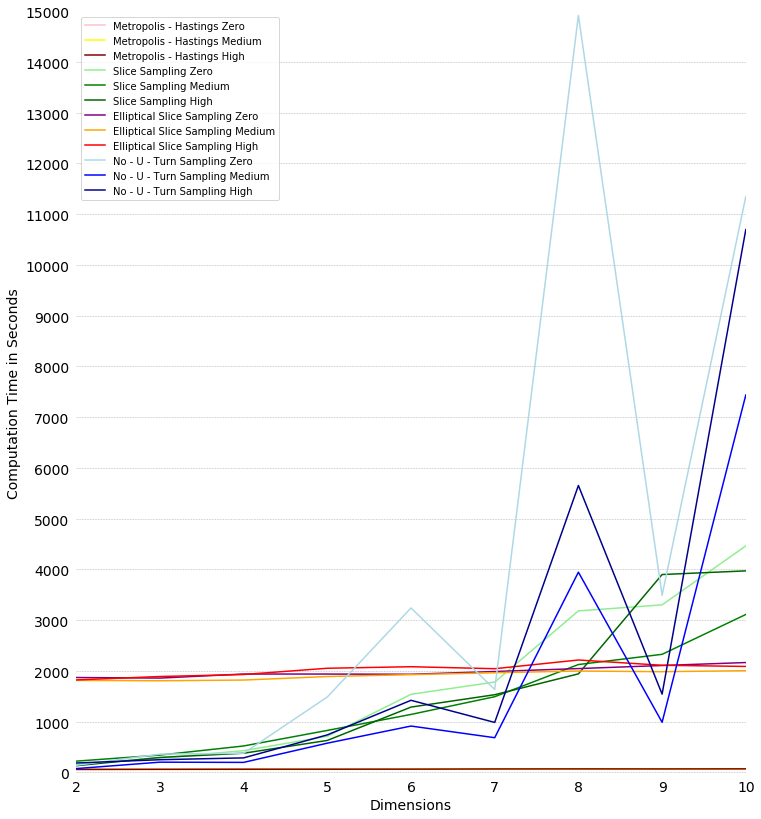

In [0]:
fig = plt.Figure()

# Read the data into a pandas DataFrame.    
Time = pd.DataFrame(Time)
 
tableau20 = ['pink', 'yellow', 'maroon', 'lightgreen', 'green', 'darkgreen', 'purple', 'orange', 'red', 'lightblue', 'blue', 'darkblue']

  
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 12000)    
plt.xlim(2, 10)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(range(0, 16000, 1000), fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in range(10, 15000, 1000):    
    ax.plot(range(2, 11), [y] * len(range(2, 11)), "--", lw=0.5, color="black", alpha=0.3)    
  
# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
Labels = ['Metropolis - Hastings Zero', 'Metropolis - Hastings Medium', 'Metropolis - Hastings High',
          'Slice Sampling Zero', 'Slice Sampling Medium', 'Slice Sampling High',
          'Elliptical Slice Sampling Zero', 'Elliptical Slice Sampling Medium', 'Elliptical Slice Sampling High',
          'No - U - Turn Sampling Zero', 'No - U - Turn Sampling Medium', 'No - U - Turn Sampling High']

j = 0

for i in Time.columns:
    ax.plot(k,Time[i], color = tableau20[j])
    j = j + 1

plt.legend()
plt.xlabel('Dimensions', fontsize = 14)
plt.ylabel('Computation Time in Seconds', fontsize = 14)

from google.colab import files
plt.savefig('Time.svg')
files.download('Time.svg') 

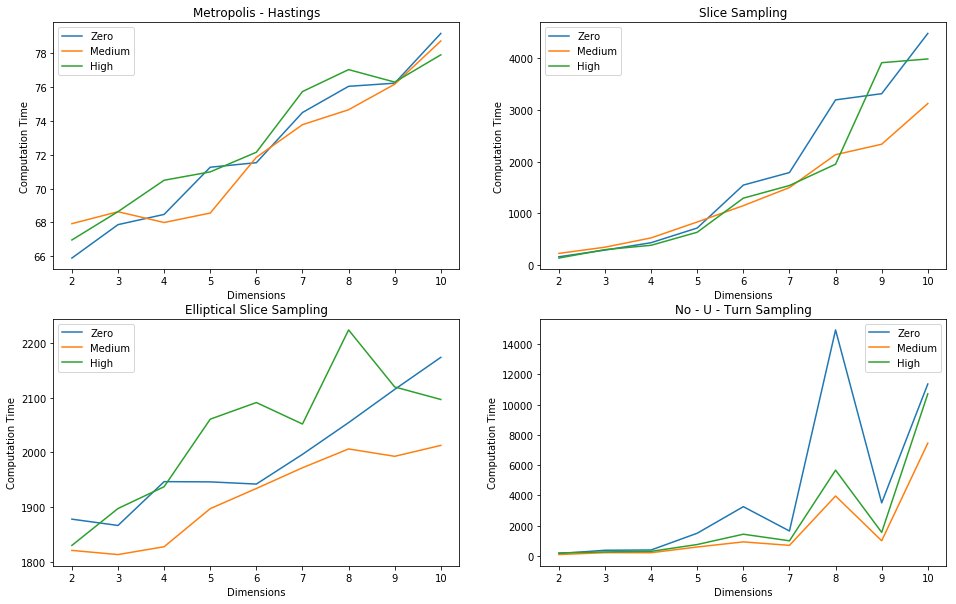

In [10]:
from pylab import *

fig = plt.figure(figsize=(16,10))

subplot(2,2,1)
title('Metropolis - Hastings')
plot(k,Met_time)
plot(k,Met_time_med)
plot(k,Met_time_high)

xlabel("Dimensions")
ylabel("Computation Time")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,2)
title('Slice Sampling')
plot(k,Slice_time)
plot(k,Slice_time_med)
plot(k,Slice_time_high)

xlabel("Dimensions")
ylabel("Computation Time")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,3)
title('Elliptical Slice Sampling')
plot(k,ESS_time)
plot(k,ESS_time_med)
plot(k,ESS_time_high)

xlabel("Dimensions")
ylabel("Computation Time")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,4)
title('No - U - Turn Sampling')
plot(k,NUTS_time)
plot(k,NUTS_time_med)
plot(k,NUTS_time_high)

xlabel("Dimensions")
ylabel("Computation Time")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

from google.colab import files
plt.gcf()
plt.savefig('Time.svg')
files.download('Time.svg')

show()

## Gelam Rubin - Convergence

In [0]:
Gelman = pd.DataFrame()
Gelman['Metropolis - Hastings Zero'] = Met_Gel
Gelman['Metropolis - Hastings Medium'] = Met_Gel_med
Gelman['Metropolis - Hastings High'] = Met_Gel_high
Gelman['Slice Sampling Zero'] = Slice_Gel
Gelman['Slice Sampling Medium'] = Slice_Gel_med
Gelman['Slice Sampling High'] = Slice_Gel_high
Gelman['Elliptical Slice Sampling Zero'] = ESS_Gel
Gelman['Elliptical Slice Sampling Medium'] = ESS_Gel_med
Gelman['Elliptical Slice Sampling High'] = ESS_Gel_high
Gelman['No - U - Turn Sampling Zero'] = NUTS_Gel
Gelman['No - U - Turn Sampling Medium'] = NUTS_Gel_med
Gelman['No - U - Turn Sampling High'] = NUTS_Gel_high

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


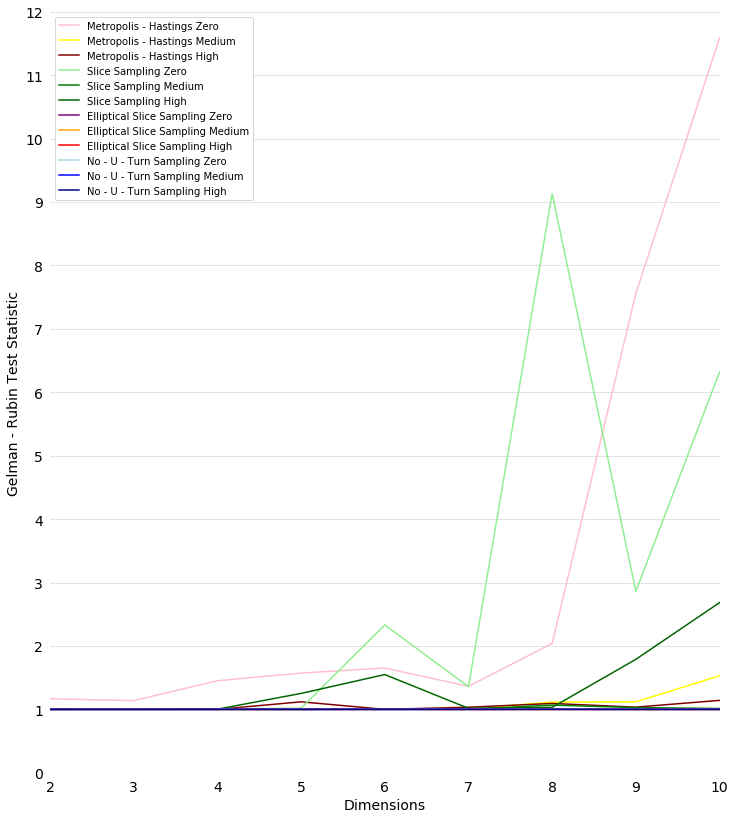

In [36]:
fig = plt.Figure()

# Read the data into a pandas DataFrame.    
Gelman = pd.DataFrame(Gelman)
 
tableau20 = ['pink', 'yellow', 'maroon', 'lightgreen', 'green', 'darkgreen', 'purple', 'orange', 'red', 'lightblue', 'blue', 'darkblue']

  
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 12)    
plt.xlim(2, 10)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(range(0, 13, 1), fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in range(0, 13, 1):    
    ax.plot(range(2, 11), [y] * len(range(2, 11)), "--", lw=0.5, color="black", alpha=0.3)    
  
# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
Labels = ['Metropolis - Hastings Zero', 'Metropolis - Hastings Medium', 'Metropolis - Hastings High',
          'Slice Sampling Zero', 'Slice Sampling Medium', 'Slice Sampling High',
          'Elliptical Slice Sampling Zero', 'Elliptical Slice Sampling Medium', 'Elliptical Slice Sampling High',
          'No - U - Turn Sampling Zero', 'No - U - Turn Sampling Medium', 'No - U - Turn Sampling High']

j = 0

for i in Gelman.columns:
    ax.plot(k,Gelman[i], color = tableau20[j])
    j = j + 1

plt.legend()
plt.xlabel('Dimensions', fontsize = 14)
plt.ylabel('Gelman - Rubin Test Statistic', fontsize = 14)

from google.colab import files
plt.savefig('Gelman.svg')
files.download('Gelman.svg') 

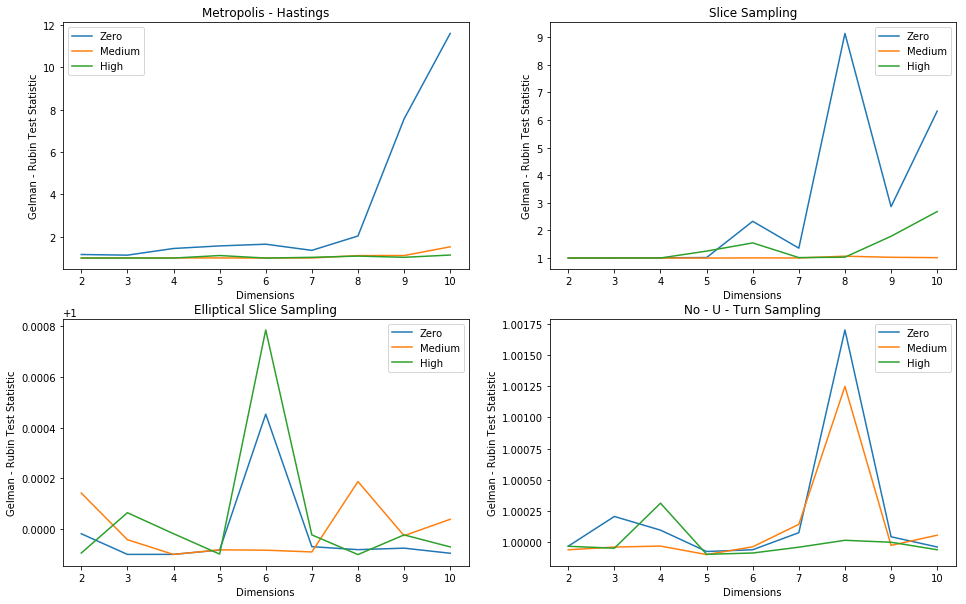

In [34]:
from pylab import *

fig = plt.figure(figsize=(16,10))

subplot(2,2,1)
title('Metropolis - Hastings')
plot(k,Met_Gel)
plot(k,Met_Gel_med)
plot(k,Met_Gel_high)

xlabel("Dimensions")
ylabel("Gelman - Rubin Test Statistic")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,2)
title('Slice Sampling')
plot(k,Slice_Gel)
plot(k,Slice_Gel_med)
plot(k,Slice_Gel_high)

xlabel("Dimensions")
ylabel("Gelman - Rubin Test Statistic")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,3)
title('Elliptical Slice Sampling')
plot(k,ESS_Gel)
plot(k,ESS_Gel_med)
plot(k,ESS_Gel_high)

xlabel("Dimensions")
ylabel("Gelman - Rubin Test Statistic")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,4)
title('No - U - Turn Sampling')
plot(k,NUTS_Gel)
plot(k,NUTS_Gel_med)
plot(k,NUTS_Gel_high)

xlabel("Dimensions")
ylabel("Gelman - Rubin Test Statistic")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

from google.colab import files
plt.gcf()
plt.savefig('Gelman.svg')
files.download('Gelman.svg')

show()

## Effective Samples - Averaged

In [0]:
Effective = pd.DataFrame()
Effective['Metropolis - Hastings Zero'] = Met_Eff
Effective['Metropolis - Hastings Medium'] = Met_Eff_med
Effective['Metropolis - Hastings High'] = Met_Eff_high
Effective['Slice Sampling Zero'] = Slice_Eff
Effective['Slice Sampling Medium'] = Slice_Eff_med
Effective['Slice Sampling High'] = Slice_Eff_high
Effective['Elliptical Slice Sampling Zero'] = ESS_Eff
Effective['Elliptical Slice Sampling Medium'] = ESS_Eff_med
Effective['Elliptical Slice Sampling High'] = ESS_Eff_high
Effective['No - U - Turn Sampling Zero'] = NUTS_Eff
Effective['No - U - Turn Sampling Medium'] = NUTS_Eff_med
Effective['No - U - Turn Sampling High'] = NUTS_Eff_high

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



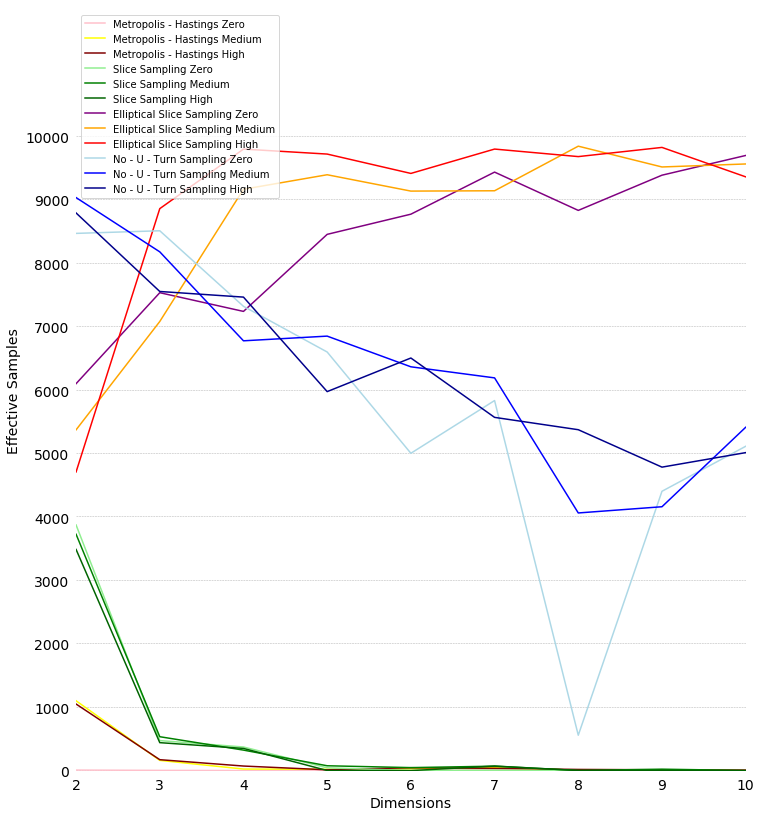

In [0]:
fig = plt.Figure()

# Read the data into a pandas DataFrame.    
Effective = pd.DataFrame(Effective)
 
tableau20 = ['pink', 'yellow', 'maroon', 'lightgreen', 'green', 'darkgreen', 'purple', 'orange', 'red', 'lightblue', 'blue', 'darkblue']

  
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 12000)    
plt.xlim(2, 10)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(range(0, 11000, 1000), fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in range(10, 11000, 1000):    
    ax.plot(range(2, 11), [y] * len(range(2, 11)), "--", lw=0.5, color="black", alpha=0.3)    
  
# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
Labels = ['Metropolis - Hastings Zero', 'Metropolis - Hastings Medium', 'Metropolis - Hastings High',
          'Slice Sampling Zero', 'Slice Sampling Medium', 'Slice Sampling High',
          'Elliptical Slice Sampling Zero', 'Elliptical Slice Sampling Medium', 'Elliptical Slice Sampling High',
          'No - U - Turn Sampling Zero', 'No - U - Turn Sampling Medium', 'No - U - Turn Sampling High']

j = 0

for i in Effective.columns:
    ax.plot(k,Effective[i], color = tableau20[j])
    j = j + 1

plt.legend()
plt.xlabel('Dimensions', fontsize = 14)
plt.ylabel('Effective Samples', fontsize = 14)

from google.colab import files
plt.savefig('Effective.svg')
files.download('Effective.svg')

In [0]:
from pylab import *

fig = plt.figure(figsize=(16,10))

subplot(2,2,1)
title('Metropolis - Hastings')
plot(k,Met_Eff)
plot(k,Met_Eff_med)
plot(k,Met_Eff_high)

xlabel("Dimensions")
ylabel("Effective Samples")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,2)
title('Slice Sampling')
plot(k,Slice_Eff)
plot(k,Slice_Eff_med)
plot(k,Slice_Eff_high)

xlabel("Dimensions")
ylabel("Effective Samples")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,3)
title('Elliptical Slice Sampling')
plot(k,ESS_Eff)
plot(k,ESS_Eff_med)
plot(k,ESS_Eff_high)

xlabel("Dimensions")
ylabel("Effective Samples")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,4)
title('No - U - Turn Sampling')
plot(k,NUTS_Eff)
plot(k,NUTS_Eff_med)
plot(k,NUTS_Eff_high)

xlabel("Dimensions")
ylabel("Effective Samples")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

from google.colab import files
plt.gcf()
plt.savefig('Effective.svg')
files.download('Effective.svg')

show()

## Standard Error Comparison

In [0]:
Mean_Met_Std_Zero = []
Mean_Met_Std_Medium = []
Mean_Met_Std_High = []
Mean_Slice_Std_Zero = []
Mean_Slice_Std_Medium = []
Mean_Slice_Std_High = []
Mean_ESS_Std_Zero = []
Mean_ESS_Std_Medium = []
Mean_ESS_Std_High = []
Mean_NUTS_Std_Zero = []
Mean_NUTS_Std_Medium = []
Mean_NUTS_Std_High = []

for i in range(9):
  Mean_Met_Std_Zero.append(np.mean(Met_Std[i]))
  Mean_Met_Std_Medium.append(np.mean(Met_Std_med[i]))
  Mean_Met_Std_High.append(np.mean(Met_Std_high[i]))
  Mean_Slice_Std_Zero.append(np.mean(Slice_Std[i]))
  Mean_Slice_Std_Medium.append(np.mean(Slice_Std_med[i]))
  Mean_Slice_Std_High.append(np.mean(Slice_Std_high[i]))
  Mean_ESS_Std_Zero.append(np.mean(ESS_Std[i]))
  Mean_ESS_Std_Medium.append(np.mean(ESS_Std_med[i]))
  Mean_ESS_Std_High.append(np.mean(ESS_Std_high[i]))
  Mean_NUTS_Std_Zero.append(np.mean(NUTS_Std[i]))
  Mean_NUTS_Std_Medium.append(np.mean(NUTS_Std_med[i]))
  Mean_NUTS_Std_High.append(np.mean(NUTS_Std_high[i]))

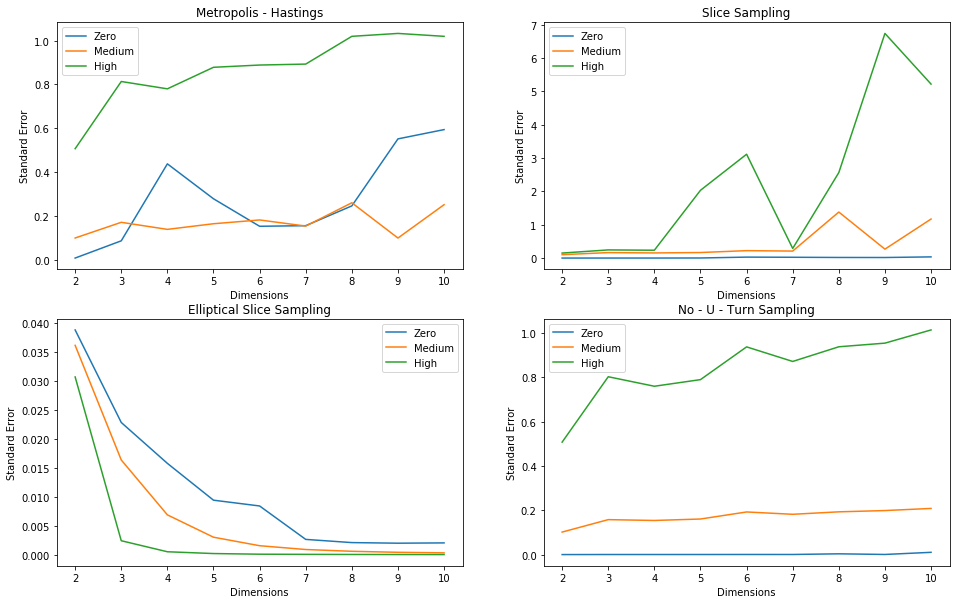

In [0]:
from pylab import *

fig = plt.figure(figsize=(16,10))

subplot(2,2,1)
title('Metropolis - Hastings')
plot(k,Mean_Met_Std_Zero)
plot(k,Mean_Met_Std_Medium)
plot(k,Mean_Met_Std_High)

xlabel("Dimensions")
ylabel("Standard Error")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,2)
title('Slice Sampling')
plot(k,Mean_Slice_Std_Zero)
plot(k,Mean_Slice_Std_Medium)
plot(k,Mean_Slice_Std_High)

xlabel("Dimensions")
ylabel("Standard Error")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,3)
title('Elliptical Slice Sampling')
plot(k,Mean_ESS_Std_Zero)
plot(k,Mean_ESS_Std_Medium)
plot(k,Mean_ESS_Std_High)

xlabel("Dimensions")
ylabel("Standard Error")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

subplot(2,2,4)
title('No - U - Turn Sampling')
plot(k,Mean_NUTS_Std_Zero)
plot(k,Mean_NUTS_Std_Medium)
plot(k,Mean_NUTS_Std_High)

xlabel("Dimensions")
ylabel("Standard Error")
Labels = ['Zero', 'Medium', 'High']
legend(Labels)

from google.colab import files
plt.gcf()
plt.savefig('Std.svg')
files.download('Std.svg')

show()